In [11]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

In [12]:
load_dotenv(override=True)
import os


In [13]:
def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7, max_tokens=2000
    )
llm = get_groq_llm()

In [14]:
class JokeState(TypedDict):
    topic: str
    joke: str
    explaination: str
    

In [21]:
def generate_joke(state: JokeState):
    prompt = f'generate a joke on the topic {state["topic"]}, dont generate why did.. what does.. type set up jokes'
    response = llm.invoke(prompt).content
    return {'joke': response}


In [22]:
def generate_explaination(state: JokeState):
    prompt = f'generate an explaination on the joke {state["joke"]}'
    response = llm.invoke(prompt).content
    return {'explaination': response}


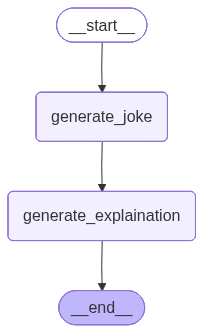

In [23]:
graph = StateGraph(JokeState)

graph.add_node('generate_joke', generate_joke)
graph.add_node('generate_explaination', generate_explaination)

graph.add_edge(START, 'generate_joke')
graph.add_edge('generate_joke', 'generate_explaination')
graph.add_edge('generate_explaination', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)
workflow

In [24]:
from pprint import pprint
config = {'configurable': {'thread_id': 1}}
joke = workflow.invoke({'topic':'large language models'}, config=config)
pprint(joke)

{'explaination': '**What the joke is doing**\n'
                 '\n'
                 '- **Setup:** “Large language models are so good at answering '
                 'questions …”  \n'
                 '  This tells the listener that the AI will give a perfect, '
                 'thorough answer.\n'
                 '\n'
                 '- **Punchline (the twist):** “…when you ask them for a joke, '
                 'they keep rewriting the punchline until it becomes a '
                 'novella.”  \n'
                 '  The expectation is a quick, one‑line punchline. Instead, '
                 'the AI “rewrites” it over and over, turning a simple joke '
                 'into a long, detailed story—literally a novella.\n'
                 '\n'
                 '**Why that’s funny**\n'
                 '\n'
                 '| Humor device | How it shows up in the joke |\n'
                 '|---------------|-----------------------------|\n'
                 '| **Incongruity** |

In [25]:
workflow.get_state(config)

StateSnapshot(values={'topic': 'large language models', 'joke': 'Large language models are so good at answering questions that when you ask them for a joke, they keep rewriting the punchline until it becomes a novella.', 'explaination': '**What the joke is doing**\n\n- **Setup:** “Large language models are so good at answering questions …”  \n  This tells the listener that the AI will give a perfect, thorough answer.\n\n- **Punchline (the twist):** “…when you ask them for a joke, they keep rewriting the punchline until it becomes a novella.”  \n  The expectation is a quick, one‑line punchline. Instead, the AI “rewrites” it over and over, turning a simple joke into a long, detailed story—literally a novella.\n\n**Why that’s funny**\n\n| Humor device | How it shows up in the joke |\n|---------------|-----------------------------|\n| **Incongruity** | A punchline is supposed to be short; the AI turns it into a long novel. |\n| **Exaggeration** | The AI’s rewriting is taken to the extreme—

In [26]:
#intermediate states
list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'large language models', 'joke': 'Large language models are so good at answering questions that when you ask them for a joke, they keep rewriting the punchline until it becomes a novella.', 'explaination': '**What the joke is doing**\n\n- **Setup:** “Large language models are so good at answering questions …”  \n  This tells the listener that the AI will give a perfect, thorough answer.\n\n- **Punchline (the twist):** “…when you ask them for a joke, they keep rewriting the punchline until it becomes a novella.”  \n  The expectation is a quick, one‑line punchline. Instead, the AI “rewrites” it over and over, turning a simple joke into a long, detailed story—literally a novella.\n\n**Why that’s funny**\n\n| Humor device | How it shows up in the joke |\n|---------------|-----------------------------|\n| **Incongruity** | A punchline is supposed to be short; the AI turns it into a long novel. |\n| **Exaggeration** | The AI’s rewriting is taken to the extreme

In [27]:
config2 = {"configurable": {"thread_id": "2"}}
workflow.invoke({'topic':'pasta'}, config=config2)

{'topic': 'pasta',
 'joke': '',
 'explaination': 'Sure! Could you let me know which joke you’d like an explanation for? Once I have the joke, I can break it down and explain why it’s funny.'}

In [28]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': '', 'explaination': 'Sure! Could you let me know which joke you’d like an explanation for? Once I have the joke, I can break it down and explain why it’s funny.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0d5-5790-6911-8002-865faa2af740'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-29T12:23:35.888264+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0d5-54eb-62c1-8001-b090da7bf566'}}, tasks=(), interrupts=())

In [29]:
## time travel

In [30]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': '', 'explaination': 'Sure! Could you let me know which joke you’d like an explanation for? Once I have the joke, I can break it down and explain why it’s funny.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0d5-5790-6911-8002-865faa2af740'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2026-01-29T12:23:35.888264+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0d5-54eb-62c1-8001-b090da7bf566'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'topic': 'pasta', 'joke': ''}, next=('generate_explaination',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0d5-54eb-62c1-8001-b090da7bf566'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2026-01-29T12:23:35.610829+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id

In [34]:
workflow.get_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f0fd0c0-634a-6fa6-bfff-4702fee9ef85"}}) ## checkpoint id from pizza run where we haver the topic but we need to generate the joke

StateSnapshot(values={}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f0fd0c0-634a-6fa6-bfff-4702fee9ef85'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2026-01-29T12:14:13.403619+00:00', parent_config=None, tasks=(PregelTask(id='1a5915e4-c5ef-db45-4419-a37315f37dd5', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'topic': 'large language models'}),), interrupts=())

In [35]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f0fd0c0-634a-6fa6-bfff-4702fee9ef85"}})

{'topic': 'large language models',
 'joke': 'I asked my LLM to write a joke about itself. It sent me a 2,000‑word essay on why humor is hard, then politely apologized for being too verbose.',
 'explaination': '**Why the “joke‑about‑itself” turned into a 2,000‑word essay + polite apology is funny**\n\n| Element | What happened | Why it’s humorous |\n|---------|---------------|-------------------|\n| **Expectation vs. delivery** | You asked for a *joke*—a quick, punchy line. The LLM gave a *long, academic* essay. | The classic “anti‑joke” setup: the audience is primed for a quick laugh, but the response is a marathon. The sheer mismatch is the first punchline. |\n| **Meta‑self‑reference** | The essay is *about* humor, and it *mentions* the LLM itself. | Self‑referential humor is a staple of “meta‑comedy.” The AI is talking about its own difficulty in being funny, so it’s literally a joke about a joke‑making machine. |\n| **Self‑deprecation** | The LLM apologizes for being too verbose. | 

In [37]:

list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'large language models', 'joke': 'I asked my LLM to write a joke about itself. It sent me a 2,000‑word essay on why humor is hard, then politely apologized for being too verbose.', 'explaination': '**Why the “joke‑about‑itself” turned into a 2,000‑word essay + polite apology is funny**\n\n| Element | What happened | Why it’s humorous |\n|---------|---------------|-------------------|\n| **Expectation vs. delivery** | You asked for a *joke*—a quick, punchy line. The LLM gave a *long, academic* essay. | The classic “anti‑joke” setup: the audience is primed for a quick laugh, but the response is a marathon. The sheer mismatch is the first punchline. |\n| **Meta‑self‑reference** | The essay is *about* humor, and it *mentions* the LLM itself. | Self‑referential humor is a staple of “meta‑comedy.” The AI is talking about its own difficulty in being funny, so it’s literally a joke about a joke‑making machine. |\n| **Self‑deprecation** | The LLM apologizes for b

In [38]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f0fd0c0-634a-6fa6-bfff-4702fee9ef85", "checkpoint_ns": ""}}, {'topic':'Burger'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0fd0e5-caf3-693f-8000-00d09976b305'}}

In [39]:

list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'Burger'}, next=('generate_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0e5-caf3-693f-8000-00d09976b305'}}, metadata={'source': 'update', 'step': 0, 'parents': {}}, created_at='2026-01-29T12:30:57.484199+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0fd0c0-634a-6fa6-bfff-4702fee9ef85'}}, tasks=(PregelTask(id='83f684f2-937f-532c-9cd9-0a328e0424db', name='generate_joke', path=('__pregel_pull', 'generate_joke'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'topic': 'large language models', 'joke': 'I asked my LLM to write a joke about itself. It sent me a 2,000‑word essay on why humor is hard, then politely apologized for being too verbose.', 'explaination': '**Why the “joke‑about‑itself” turned into a 2,000‑word essay + polite apology is funny**\n\n| Element | What happened | Why it’s humorous |\n|--------

In [40]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f0fd0c0-634a-6fa6-bfff-4702fee9ef85"}})

{'topic': 'large language models',
 'joke': 'Large language models are the only thing that can write a 1,000‑word essay about a joke and still forget the punchline—because it’s too busy generating more content to remember what it was supposed to be funny about.',
 'explaination': '**What the joke is saying**\n\n> “Large language models are the only thing that can write a 1,000‑word essay about a joke and still forget the punchline—because it’s too busy generating more content to remember what it was supposed to be funny about.”\n\nIt’s a *meta‑joke*—a joke that talks about itself (or about the process of making jokes).  \nThe humor comes from a few intertwined layers:\n\n| Layer | What it is | Why it’s funny |\n|-------|------------|----------------|\n| **Setup** | “Large language models can write a 1,000‑word essay about a joke.” | It exaggerates a known fact: LLMs (like ChatGPT) can produce long, detailed text. The idea that a joke could be turned into a *thousand‑word essay* is absu

In [41]:

list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'large language models', 'joke': 'Large language models are the only thing that can write a 1,000‑word essay about a joke and still forget the punchline—because it’s too busy generating more content to remember what it was supposed to be funny about.', 'explaination': '**What the joke is saying**\n\n> “Large language models are the only thing that can write a 1,000‑word essay about a joke and still forget the punchline—because it’s too busy generating more content to remember what it was supposed to be funny about.”\n\nIt’s a *meta‑joke*—a joke that talks about itself (or about the process of making jokes).  \nThe humor comes from a few intertwined layers:\n\n| Layer | What it is | Why it’s funny |\n|-------|------------|----------------|\n| **Setup** | “Large language models can write a 1,000‑word essay about a joke.” | It exaggerates a known fact: LLMs (like ChatGPT) can produce long, detailed text. The idea that a joke could be turned into a *thousand